# What if... I take all the features, run the VIF and fit the model with the filtered features?

In [156]:
import pandas as pd
import plotly.express as px
from statsmodels.stats.outliers_influence import variance_inflation_factor
from tinyshift.stats import BootstrapBCA
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import het_goldfeldquandt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score


In [89]:
df = pd.read_csv("./data/cancer_reg.csv", encoding='iso-8859-1')

In [90]:
df = df[df['MedianAge'] <= 90]

## Percentage of Total of NaN Data for Each Column

In [91]:
df.isnull().sum() / len(df)

avgAnnCount                0.000000
avgDeathsPerYear           0.000000
TARGET_deathRate           0.000000
incidenceRate              0.000000
medIncome                  0.000000
popEst2015                 0.000000
povertyPercent             0.000000
studyPerCap                0.000000
binnedInc                  0.000000
MedianAge                  0.000000
MedianAgeMale              0.000000
MedianAgeFemale            0.000000
Geography                  0.000000
AvgHouseholdSize           0.000000
PercentMarried             0.000000
PctNoHS18_24               0.000000
PctHS18_24                 0.000000
PctSomeCol18_24            0.750083
PctBachDeg18_24            0.000000
PctHS25_Over               0.000000
PctBachDeg25_Over          0.000000
PctEmployed16_Over         0.049387
PctUnemployed16_Over       0.000000
PctPrivateCoverage         0.000000
PctPrivateCoverageAlone    0.199536
PctEmpPrivCoverage         0.000000
PctPublicCoverage          0.000000
PctPublicCoverageAlone     0

In [92]:
df = df.drop(columns=["PctSomeCol18_24", "PctPrivateCoverageAlone"])

In [93]:
bca = BootstrapBCA()
bca.compute_interval(df["PctEmployed16_Over"].dropna(), confidence_level=0.95, statistic=np.mean, n_resamples=1000)

(53.82614569603778, 54.43873685962987)

In [94]:
df["PctEmployed16_Over"] = df["PctEmployed16_Over"].fillna(np.ceil(df["PctEmployed16_Over"].mean()))

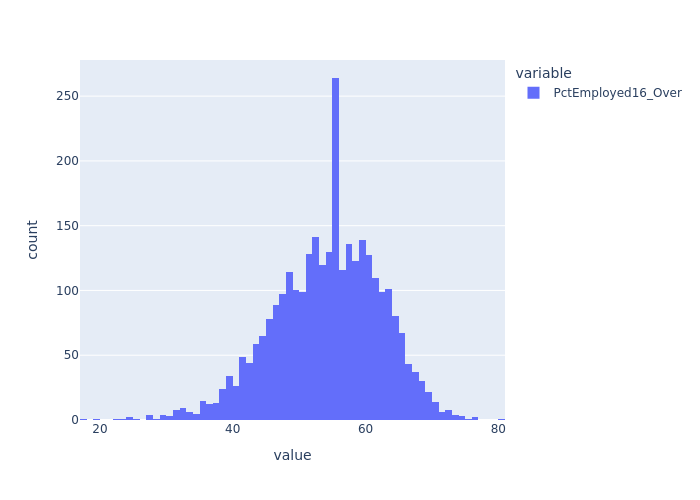

In [86]:
px.histogram(df["PctEmployed16_Over"]).show("png")

In [96]:
def filtering_features_based_on_vif(X: np.ndarray, threshold=15.0, verbose=False):
    """
    Filter features based on Variance Inflation Factor (VIF).
    Features with VIF above the threshold are removed iteratively."""

    if not isinstance(threshold, (int, float)):
        raise ValueError("Threshold must be a numeric value.")
    if not isinstance(verbose, bool):
        raise ValueError("Verbose must be a boolean value.")
    if X.size == 0:
        raise ValueError("Input X cannot be empty.")
    if X.shape[0] < 2:
        raise ValueError("Input X must have at least two samples.")
    if X.shape[1] < 2:
        raise ValueError("Input X must have at least two features.")

    X = np.asanyarray(X)
    features = np.ones(X.shape[1], dtype=bool)
    for _ in range(features.shape[0]):
        vif = np.zeros(features.shape[0])
        mask = np.where(features)
        vif[mask] = [variance_inflation_factor(X[:, features], i) for i in range(X[:, features].shape[1])]
        max_vif = max(vif)
        idx_max_vif = np.argmax(vif)
        if max_vif >= threshold:
            if verbose:
                print(f"Index of feature with max VIF: {idx_max_vif}")
                print(f"Removing feature with VIF: {max_vif}")
            features[idx_max_vif] = False
            continue
        else:
            break
    return features

In [100]:
df[["TARGET_deathRate", "binnedInc"]]

,TARGET_deathRate,binnedInc
0,164.9,"(61494.5, 125635]"
1,161.3,"(48021.6, 51046.4]"
2,174.7,"(48021.6, 51046.4]"
3,194.8,"(42724.4, 45201]"
4,144.4,"(48021.6, 51046.4]"
...,...,...
3042,149.6,"(45201, 48021.6]"
3043,150.1,"(48021.6, 51046.4]"
3044,153.9,"(51046.4, 54545.6]"
3045,175.0,"(48021.6, 51046.4]"


In [114]:
features_in = df.columns.drop(["TARGET_deathRate", "binnedInc", "Geography"])

In [119]:
mask_features = filtering_features_based_on_vif(df[features_in], threshold=5)
filtered_features = [feature for feature, choosen in zip(features_in, mask_features) if choosen]

In [121]:
def corr_heatmap(df, width=1600, height=1600, fig_type=None):
    """   
    Generate a correlation heatmap for the DataFrame.
    """
    fig = px.imshow(df.corr(numeric_only=True), text_auto=True, aspect="equal", color_continuous_scale='RdBu_r', title='Heatmap of Correlation Coefficients')
    fig.update_layout(width=width, height=height)
    return fig.show(fig_type)

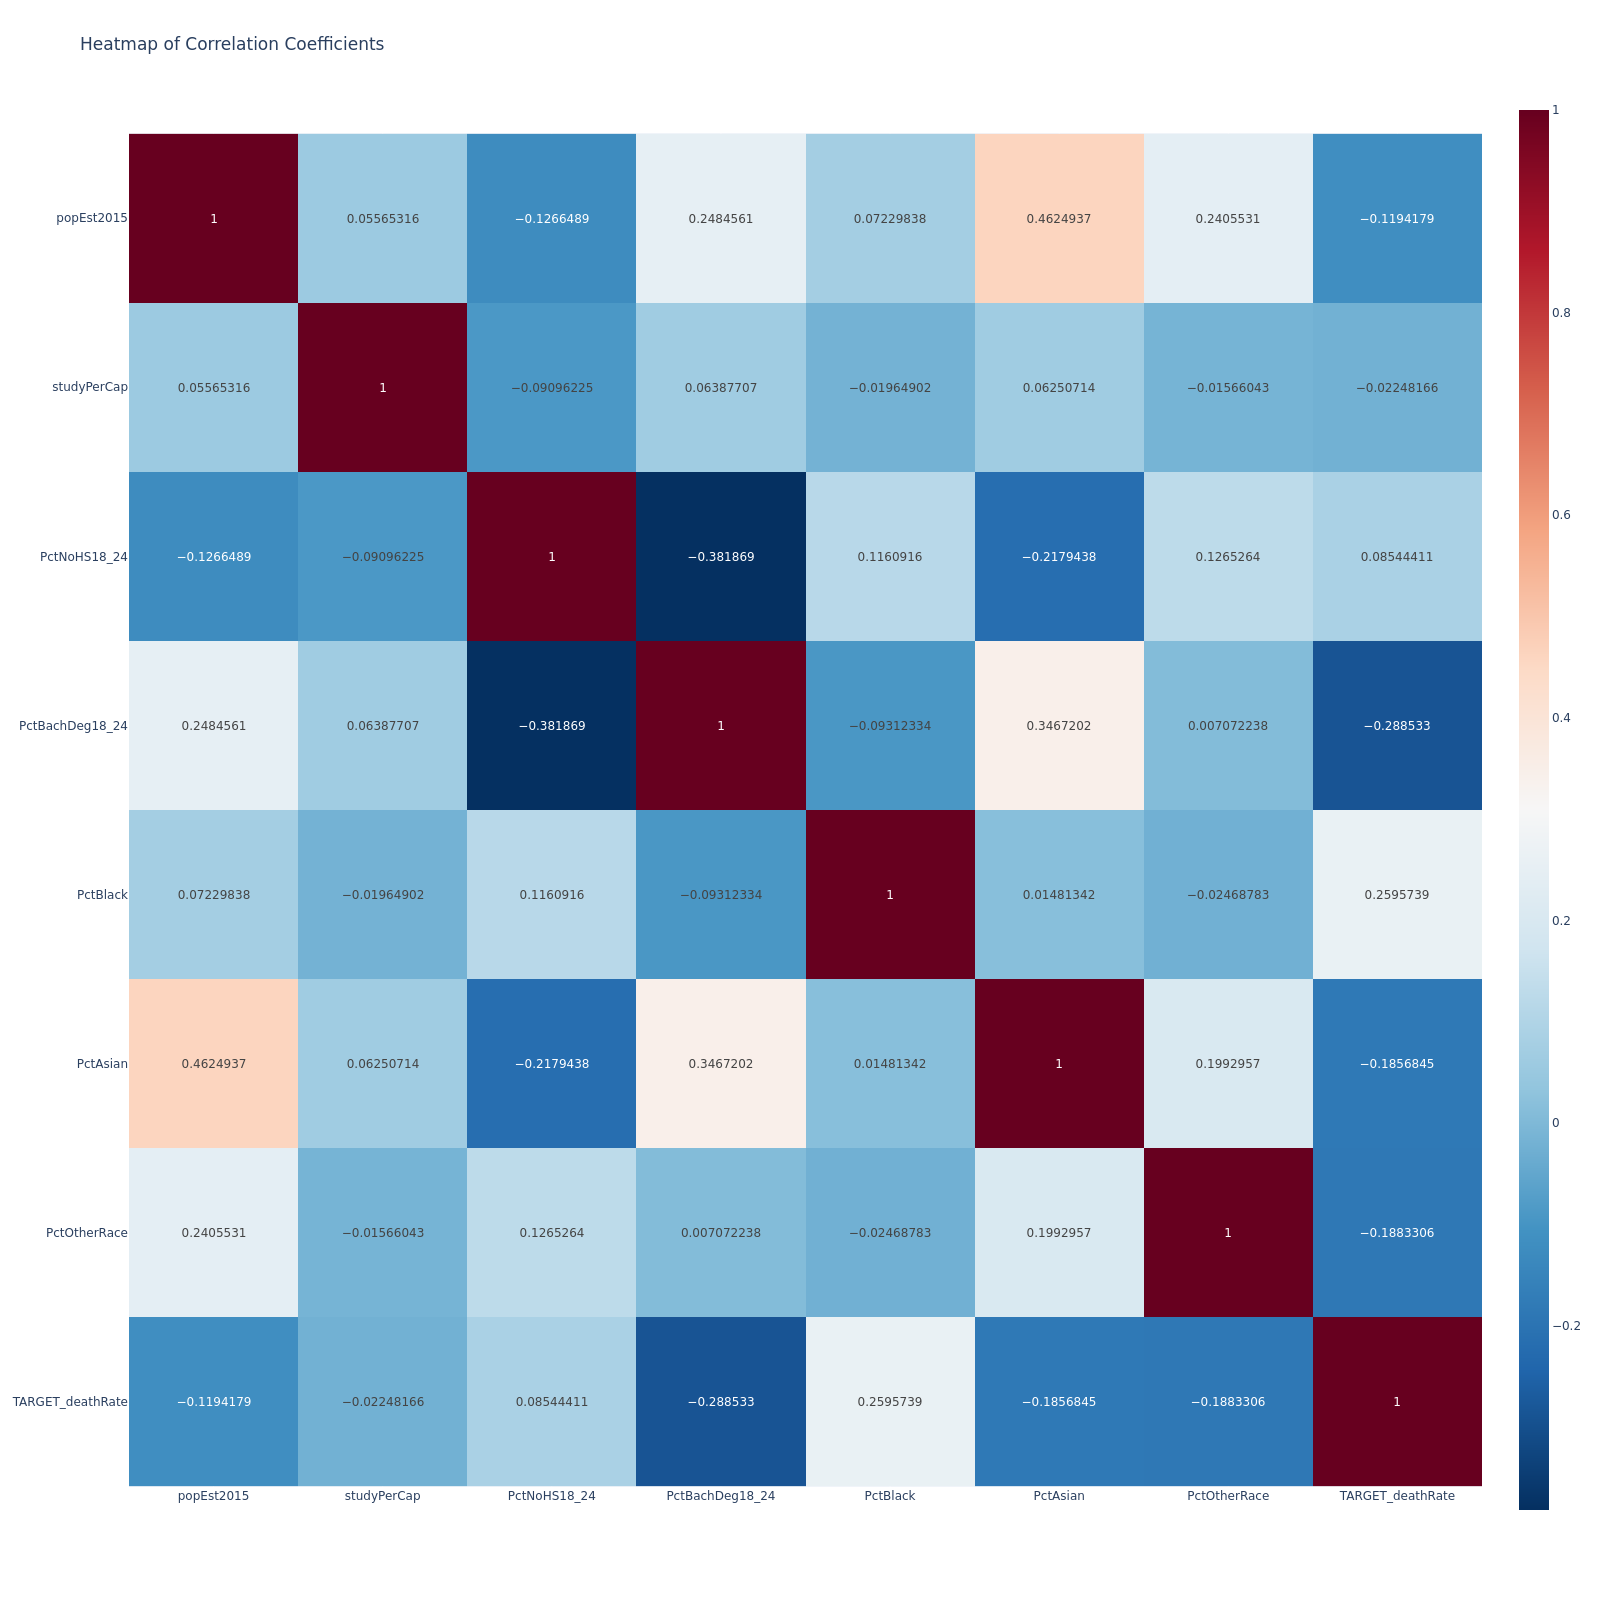

In [122]:
corr_heatmap(df[filtered_features + ["TARGET_deathRate"]], width=1600, height=1600, fig_type="png")

In [126]:
def plot_barplot_corr_with_target(df, target='TARGET_deathRate'):
    corr = df.corr(numeric_only=True)[target].drop(target).sort_values()
    plt.figure(figsize=(8, 12))
    sns.barplot(x=corr.values, y=corr.index, palette='RdBu_r')
    plt.title(f'Correlation Coefficients from {target}')
    plt.xlabel('Correlation Coefficients')
    plt.ylabel('Feature')
    plt.show()

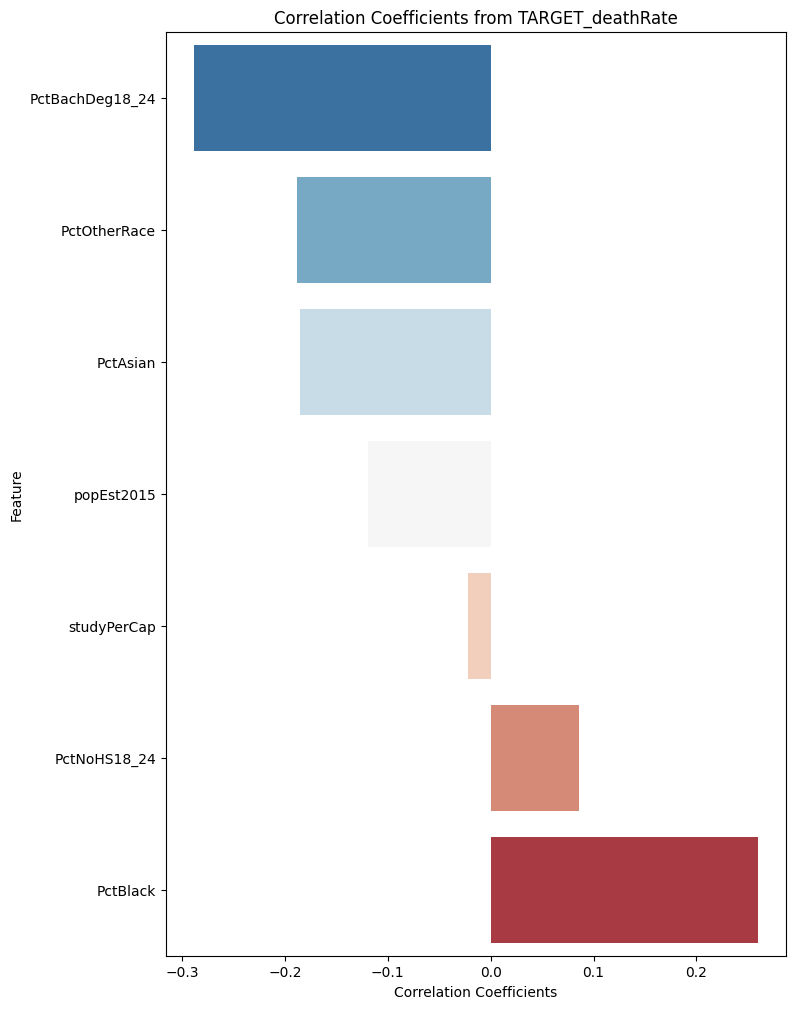

In [128]:
plot_barplot_corr_with_target(df[filtered_features + ['TARGET_deathRate']])

In [130]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)

In [132]:
model = LinearRegression()

In [146]:
model.fit(df_train[filtered_features], df_train['TARGET_deathRate'])

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [147]:
y_pred = model.predict(df_test[filtered_features])
y_test = df_test['TARGET_deathRate']

<Axes.ArtistList of 2 lines>

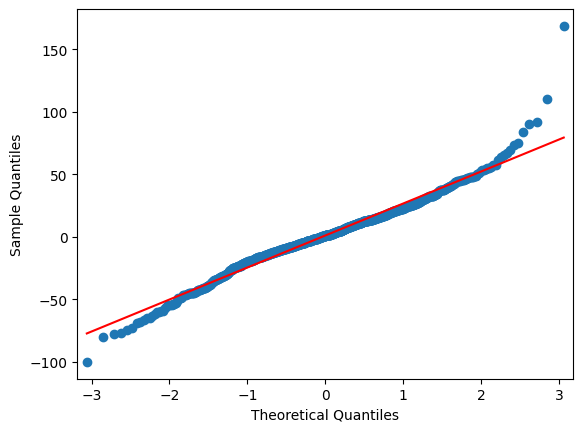

In [148]:
residuals = y_test - y_pred
qqplot(residuals, line='s').gca().lines

In [149]:
# Goldfeld-Quandt test
gq_test = het_goldfeldquandt(residuals, df_test[filtered_features])
print("Goldfeld-Quandt test:")
print(f"F-stat: {gq_test[0]}, p-value: {gq_test[1]}\n")

Goldfeld-Quandt test:
F-stat: 0.8685513148798883, p-value: 0.9314486227194817



In [150]:
def standardize_coefficients(model: LinearRegression, df_train: pd.DataFrame):
    """
    Standardize the coefficients of the model based on the standard deviation of the features and target.
    """
    std_coef = np.zeros(len(model.coef_))
    for i in range(len(model.feature_names_in_)):
        std_coef[i] = model.coef_[i] * df_train[model.feature_names_in_[i]].std() / df_train['TARGET_deathRate'].std()
    return std_coef

In [151]:
model.feature_importance_ = standardize_coefficients(model, df_train)

In [152]:
feature_importance = pd.DataFrame({
    'feature': model.feature_names_in_,
    'std_coef': model.feature_importance_
}).sort_values(by='std_coef', ascending=False).reset_index(drop=True)

In [153]:
feature_importance

,feature,std_coef
0,PctBlack,0.219435
1,popEst2015,0.018996
2,studyPerCap,-0.007221
3,PctNoHS18_24,-0.033383
4,PctAsian,-0.074340
5,PctOtherRace,-0.178244
6,PctBachDeg18_24,-0.267366


In [155]:
X = sm.add_constant(df_train[filtered_features]) # add intercept
y = df_train["TARGET_deathRate"]
model_sm = sm.OLS(y, X).fit()
model_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       TARGET_deathRate   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     63.03
Date:                Thu, 17 Jul 2025   Prob (F-statistic):           1.47e-82
Time:                        13:11:05   Log-Likelihood:                -9792.0
No. Observations:                2111   AIC:                         1.960e+04
Df Residuals:                    2103   BIC:                         1.965e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             190.8089      1.949     97.914      0.000     186.987     194.630
popEst2015       1.929e-06   2.37e-06      0.815      0.415   -2.71e-06    6.57e-06
studyPerCap        -0.0004      0.001     -0.362      0.717      -0.002       0.002
PctNoHS18_24       -0.1116      0.074     -1.504      0.133      -0.257       0.034
PctBachDeg18_24    -1.7035      0.147    -11.567      0.000      -1.992      -1.415
PctBlack            0.4214      0.039     10.856      0.000       0.345       0.497
PctAsian           -0.8011      0.252     -3.182      0.001      -1.295      -0.307
PctOtherRace       -1.4460      0.172     -8.390      0.000      -1.784      -1.108
==============================================================================
Omnibus:                       66.223   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              142.336
Skew:                           0.173   Prob(JB):                     1.24e-31
Kurtosis:                       4.224   Cond. No.                     1.03e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.03e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [157]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mse, r2

(656.268153773062, 0.17544406420884062)